<a href="https://colab.research.google.com/github/ShezaMunir/NeuralNetwork/blob/main/Sheza_group16_Phase2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### <b>Introduction</b> 
This is the second of the three phases of this offering's project. Having implemented a neural network from scratch using for loops, you will now be using vectorization (wherever applicable) to improve the performance of the model and equip it to deal with the complete Fashion MNIST Dataset.

The dataset consists of 70,000 images of fashion/clothing items belonging to 10 different categories/classes. It has furhter been divided into 60,000 training images and 10,000 test images and each image is a 28*28 grayscale image (hence 1 color channel). It is recommended that you go through  [this link](https://www.kaggle.com/zalando-research/fashionmnist) to familiarize yourself with the dataset.

In this phase, you will load the required dataset from the keras datasets library. To get the best results, you will need to tweak hyperparameters, and the best values will not necessarily be the ones you performed for your computations in phase 1 with.

###### <b>IMPORTANT

In this phase, you will be required to implement multiple hidden layers (>= 2) alongside the input and output layer, as opposed to the one you implemented in phase 1. This may require some revision to the logic of the code you use.

###### Modification of the provided code without prior discussion with the TAs will result in a grade deduction</b>

---

###### <b>Side note</b>
The `plot_model` method will only work if you have the `pydot` python package installed along with [Graphviz](https://graphviz.gitlab.io/download/). If you do not wish to use this then simply comment out the import for `pydot`

###### <b>Need Help?</b>
If you need help, please refer to the course staff ASAP and do not wait till the last moment as they might not be available on very short notice close to deadlines

#### <b>Before You Begin</b>

The main methods that you need to implement correspond to the four steps of the training process of a NN which are as follows:
1. Initialize variables and initialize weights
2. Forward pass
3. Backward pass AKA Backpropogation
4. Weight Update AKA Gradient Descent

 

A `fit` function is what combines the previous three functions and overall trains the network to __fit__ to the provided training examples. The provided `fit` methods requires all the four steps of the training process to be working correctly. The function has been setup in a way that it expects the above four methods to take particular inputs and return particular outputs. __You are supposed to work within this restriction__ 



__To see if your model is working correctly, you need to make sure that your model loss is going down during training__

__The number of hidden layers needs to be >= 2, and the implementation should not crash if we attempt to arbitrarily change it__


In [ ]:
# making all the necessary imports here

import numpy as np
import pandas as pd
import time
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn')
from IPython.display import Image
import pydot
from tqdm import tqdm_notebook
import seaborn as sns
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.datasets import make_moons
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import confusion_matrix,classification_report
from google.colab import drive
import glob
import cv2
from numba import jit

In [ ]:
# This function will be used to plot the confusion matrix at the end of this notebook

def plot_confusion_matrix(conf_mat):
    classes = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']
    df_cm = pd.DataFrame(conf_mat,classes,classes)
    plt.figure(figsize=(15,9))
    sns.set(font_scale=1.4)
    sns.heatmap(df_cm, annot=True,annot_kws={"size": 16})
    plt.show()

class_labels = ['T-shirt/top','Trouser/pants','Pullover shirt','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle boot']

In [ ]:
# Enter group lead's roll number here. This will be used for plotting purposes

rollnumber = 23100116

#### __Dataset from Keras Library__

The required library has been imported for you as fashion_mnist. Use it to load the train and test data accordingly.

In [ ]:
classes = 10 # Do not change this
# Download Fashion MNIST dataset
###### Code Here ######

# Split the fashion MNIST dataset into train and test sets

((trainX, trainY),(testX, testY)) = fashion_mnist.load_data()

# Convert y_train and y_test to categorical binary values 
###### Code Here ######

from tensorflow.keras.utils import to_categorical

y_train = to_categorical(trainY,classes)
y_test = to_categorical(testY,classes)

#Reshape train and test images as one-dimensional arrays
###### Code Here ######

X_train = trainX.reshape(60000,1,784)
X_train = X_train / 255.0

X_test = testX.reshape(10000,1,784)
X_test = X_test / 255.0

print(X_train.shape) # clarify with TA if this is what's meant by 1D arrays (i.e 60000 1D arrays)
print(X_test.shape)

(60000, 1, 784)
(10000, 1, 784)


#### __NN Implementation__
Your implementation of NN needs to use the `sigmoid` activation function for all hidden layers and the `softmax` activation function for the output layer. The NN model you will be creating here will consits of only three layers: 1 input layer, n hidden layers (where you have the liberty to define n) and 1 output layer.

In [ ]:
class NeuralNetwork():
    @staticmethod
    def cross_entropy_loss(y_pred, y_true):
      # y_pred = np.log(y_pred)
      cross_entropy_loss = -np.sum(y_true*np.log(y_pred))
      return cross_entropy_loss

    @staticmethod
    def accuracy(y_pred, y_true):
      accurate = 0.0
      num_pred = len(y_pred)
      for i in range(num_pred):
        if y_pred[i] == y_true[i]:
          accurate = accurate + 1
      accuracy = accurate/num_pred
      return accuracy

    @staticmethod
    def softmax(x):
        # implement softmax function
        #TO DO
        ans = np.exp(x)/np.sum(np.exp(x), axis = 0)

        return ans

    @staticmethod
    def sigmoid(x):
        #TO DO
        ans = 1.0 / (1.0 + np.exp(-x))
        return ans

    def __init__(self, nodes_per_layer):
        '''Creates a Feed-Forward Neural Network.
        The parameters represent the number of nodes in each layer. 
        Look at the inputs to the function, and use 'try and accept'
        to catch errors if number of layers are < 2.
        '''
        
        self.num_layers = len(nodes_per_layer) # including input and output layers
        self.nodes_per_layer = nodes_per_layer #[32, 16] 32 nodes in first hidden layer and 16 nodes in second hidden layer
        self.input_shape = nodes_per_layer[0]
        self.output_shape = nodes_per_layer[-1]

        self.weights_ = []
        self.biases_ = []
        self.__init_weights(nodes_per_layer)

    def __init_weights(self, nodes_per_layer):
        '''Initializes all weights based on standard normal distribution and all biases to 0.'''
        '''Initialize weights for each layer except the input layer, since it does not have weights.'''
        
        ###### Code Here ######
        hidden = self.nodes_per_layer.copy()
        hidden.pop(0)
        hidden.pop()
        self.weights_.append(np.random.normal(size=(hidden[0],self.input_shape))) # 32 x 784
        self.biases_.append(np.zeros(shape = (hidden[0], 1))) # 32 x 1
        for i in range (1,(self.num_layers-2)): #loop runs from 1 to no of layers - 2 bc no of layers -1 is like for hidden to output
          self.weights_.append(np.random.normal(size=(hidden[i],hidden[i-1]))) # n x n-1 = 16 x 32
          self.biases_.append(np.zeros(shape = (hidden[i], 1))) # n x 1 = 16 x 1
        self.weights_.append(np.random.normal(size=(self.output_shape,hidden[len(hidden)-1]))) #10 x n = 10 x 16
        self.biases_.append(np.zeros(shape=(self.output_shape, 1))) #10 x 1
        #basically to access weights or biases you do self.weights_[layer_num-1] (if considering input layer layer 1)
        
        
    
    def forward_pass(self, input_data):
        '''Executes the feed forward algorithm.
        "input_data" is the input to the network in row-major form
        Returns "activations", which is a list of all layer outputs (excluding input layer of course)'''
        
        ###### Code Here ######
        
        activations =[]
        activations.append(input_data)
        # figuring out for input to hidden
        # input : 1 x 784
        # input.t : 784 x 1
        # weights: 32 x 784
        # output: 32 x 1 
        # weights*input = 32 x 784 * 784 x 1 = 32 x 1
        activations.append(self.sigmoid((np.matmul(self.weights_[0],np.transpose(input_data)))+ self.biases_[0])) # 32 x 1
        #for each hidden to hidden the input would be the prev layer
        #weights = 16 x 32
        #activations = 32 x 1
        #new activations = 16 x 32 * 32 x 1 = 16 x 1
        for i in range(1,(self.num_layers-2)):
          activations.append(self.sigmoid((np.matmul(self.weights_[i],activations[i])) + self.biases_[i])) # 16 x 1
        #hidden to output
        #weights: 10 x 16
        #activation: 16 x 1
        #new activation: 10 x 1
        activations.append(self.softmax((np.matmul(self.weights_[self.num_layers-2],activations[self.num_layers-2])) + self.biases_[self.num_layers-2])) #10 x 1

        
        return activations
    
    def backward_pass(self, targets, layer_activations):
        '''Executes the backpropogation algorithm.
        "targets" is the ground truth/labels
        "layer_activations" are the return value of the forward pass step
        Returns "deltas", which is a list containing weight update values for all layers (excluding the input layer of course)'''
        
        ###### Code Here ######
        deltas = [] # index 0 and 1 have last layers weight and bias updates

        #Danyal - Final Version
        hidden_layers = []
        input_layer = np.transpose(layer_activations[0]) # 784 X 1
        hidden_layers.append(input_layer)
        for i in range(len(layer_activations) - 2):
          hidden_layers.append(layer_activations[i + 1].reshape(layer_activations[i + 1].shape[0], -1))
        output_layer = layer_activations[len(layer_activations) - 1].reshape(layer_activations[len(layer_activations) - 1].shape[0], -1) # 10 X 1

        err_coefficients = []
        softmax_deriv = np.multiply(output_layer, (1 - output_layer)) # 10 X 1
        cel_deriv = -(targets.transpose()/output_layer) + ((1 - targets.transpose())/(1 - output_layer)) #10 X 1
        err_const = np.multiply(softmax_deriv, cel_deriv)
        err_coefficients.append(err_const)
        hidden_temp = hidden_layers[-1].transpose()
        deltas.append(np.matmul(err_const, hidden_temp))
        deltas.append(err_const)

        for i in range(self.num_layers - 2):
          de_dy_temp = np.multiply(self.weights_[self.num_layers - 2 - i], err_coefficients[i])
          de_dy = (np.sum(de_dy_temp, axis=0, keepdims=True)).transpose() 
          sig_der = np.multiply(hidden_layers[self.num_layers - 2 - i], (1 - hidden_layers[self.num_layers - 2 - i]))
          hidden_const = np.multiply(de_dy, sig_der)
          err_coefficients.append(hidden_const)
          hidden_temp = hidden_layers[self.num_layers - 3 - i].transpose()
          deltas.append(np.matmul(hidden_const, hidden_temp))
          deltas.append(hidden_const)
        
        return deltas
    
    def weight_update(self, deltas, layer_inputs, lr):
        '''Executes the gradient descent algorithm.
        "deltas" is return value of the backward pass step
        "layer_inputs" is a list containing the inputs for all layers (including the input layer)
        "lr" is the learning rate'''
        
        ###### Code Here ######

        #deltas starts from last layer and has 2 entries for each
        total = self.num_layers - 1
        for i in range(self.num_layers - 1):
          self.weights_[i] = self.weights_[i] - lr*deltas[2*(total - i) - 2]
          self.biases_[i] = self.biases_[i] - lr*deltas[2*(total - i) - 1] 
 
    
    ###### Do Not Change Anything Below this line in This Cell ######
    
    def fit(self, Xs, Ys, epochs, lr=1e-3):
            history = []
            for epoch in tqdm_notebook(range(epochs)):
                num_samples = Xs.shape[0]
                for i in range(num_samples):

                    sample_input = Xs[i,:].reshape((1,self.input_shape))
                    sample_target = Ys[i,:].reshape((1,self.output_shape))
                    
                    activations = self.forward_pass(sample_input)   # Call forward_pass function 
                    deltas = self.backward_pass(sample_target, activations)    # Call backward_pass function 
                    layer_inputs = [sample_input] + activations[:-1]
                    
                    # Call weight_update function 
                    self.weight_update(deltas, layer_inputs, lr)
                
                preds = self.predict(Xs)   # Call predict function 

                current_loss = self.cross_entropy_loss(preds, Ys)
                
                if  epoch==epochs-1:
                  confusion_mat=confusion_matrix(Ys.argmax(axis=1), preds.argmax(axis=1),labels=np.arange(10))  
                  plot_confusion_matrix(confusion_mat)
                  report = classification_report(Ys, np_utils.to_categorical(preds.argmax(axis=1),num_classes=classes), target_names=class_labels)
                  print(report)
                history.append(current_loss)
            return history
    
    def predict(self, Xs):
        '''Returns the model predictions (output of the last layer) for the given "Xs".'''
        predictions = []
        num_samples = Xs.shape[0]
        for i in range(num_samples):
            sample = Xs[i,:].reshape((1,self.input_shape))
            sample_prediction = self.forward_pass(sample)[-1]
            predictions.append(sample_prediction.reshape((self.output_shape,)))
        return np.array(predictions)
    
    def evaluate(self, Xs, Ys):
        '''Returns appropriate metrics for the task, calculated on the dataset passed to this method.'''
        pred = self.predict(Xs)
        return self.cross_entropy_loss(pred, Ys), self.accuracy(pred.argmax(axis=1), Ys.argmax(axis=1))
    
    def plot_model(self, filename):
        '''Provide the "filename" as a string including file extension. Creates an image showing the model as a graph.'''
        graph = pydot.Dot(graph_type='digraph')
        graph.set_rankdir('LR')
        graph.set_node_defaults(shape='circle', fontsize=0)
        nodes_per_layer = [self.input_shape, self.hidden_shape, self.output_shape]
        for i in range(self.num_layers-1):
            for n1 in range(nodes_per_layer[i]):
                for n2 in range(nodes_per_layer[i+1]):
                    edge = pydot.Edge(f'l{i}n{n1}', f'l{i+1}n{n2}')
                    graph.add_edge(edge)
        graph.write_png(filename)

In [ ]:
# These are what we call the hyperparameters (a.k.a Black Magic). You need to research on them and tweak them to see what generates the best result for you 

EPOCH = 100     # must be an int
LEARNING_RATE = 0.0015
nodes_per_layer = [784, 72, 24, 10]  #int values for nodes of each layer. # of hidden layers >= 2. 


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:155: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


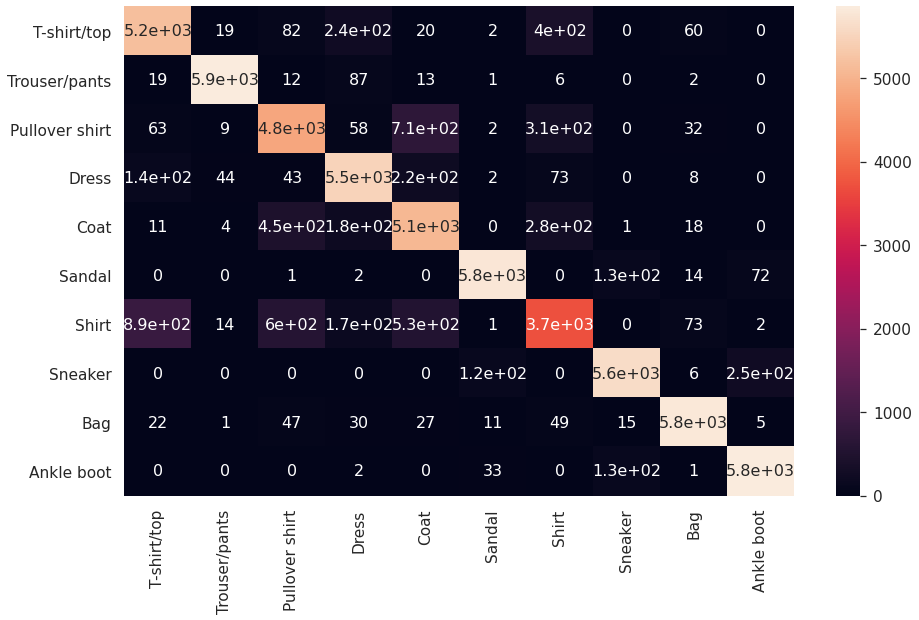

                precision    recall  f1-score   support

   T-shirt/top       0.82      0.86      0.84      6000
 Trouser/pants       0.98      0.98      0.98      6000
Pullover shirt       0.80      0.80      0.80      6000
         Dress       0.88      0.91      0.89      6000
          Coat       0.77      0.84      0.80      6000
        Sandal       0.97      0.96      0.97      6000
         Shirt       0.77      0.62      0.69      6000
       Sneaker       0.95      0.94      0.95      6000
           Bag       0.96      0.97      0.96      6000
    Ankle boot       0.95      0.97      0.96      6000

     micro avg       0.89      0.89      0.89     60000
     macro avg       0.89      0.89      0.88     60000
  weighted avg       0.89      0.89      0.88     60000
   samples avg       0.89      0.89      0.89     60000


Runtime of the algorithm is  4171.279  seconds
(4369.433217137357, 0.848)


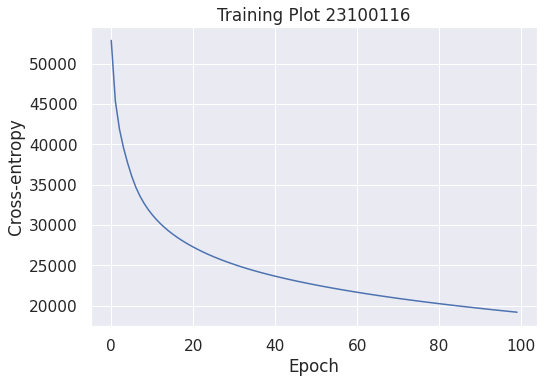

In [ ]:
start = time.time()

# Instantiate the neural network with the number of nodes you choose per layer, right now it is done for three layers only.
nn = NeuralNetwork(nodes_per_layer=nodes_per_layer)
history = nn.fit(X_train, y_train, epochs=EPOCH, lr=LEARNING_RATE)
plt.plot(history);
plt.gca().set(xlabel='Epoch', ylabel='Cross-entropy', title='Training Plot {}'.format(rollnumber));
end = time.time()

print("Runtime of the algorithm is ", round((end - start),3)," seconds")

# print accuracy on test set here
print(nn.evaluate(X_test,y_test))